In [1]:
import os
from pathlib import Path

import numpy as np
import cv2
import albumentations as albu
import albumentations.pytorch

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from models import EfficientNetEncoder, EncoderGlobalFeatures

from utils import t2d, ImagesDataset

%matplotlib inline

In [2]:
torch.autograd.set_detect_anomaly(False)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
DATA_DIR = "imagewoof2-320"

valid_transforms = albu.Compose([
    albu.Resize(224, 224),
    albu.Normalize(),
    albu.pytorch.ToTensorV2()
])

classes = sorted(set(os.listdir(os.path.join(DATA_DIR, "train"))))

class2index = {item: num for num, item in enumerate(classes)}

def _images_and_classes(folder):
    files, targets = [], []
    for file in folder.glob("*/*.JPEG"):
        image_folder = str(file).split("/")[-2]
        files.append(str(file))
        targets.append(class2index[image_folder])
    return files, targets

In [4]:
valid_dataset = ImagesDataset(
    *_images_and_classes(Path(DATA_DIR) / "val"), transforms=valid_transforms
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=os.cpu_count(),
    drop_last=False,
)

In [5]:
device = torch.device("cuda:0")

encoder = EfficientNetEncoder("efficientnet-b1")
model = EncoderGlobalFeatures(encoder, emb_dim=3, num_classes=10)

model.load_state_dict(torch.load("global_features.pth", map_location=device)["model_state_dict"])

model = model.to(device)

Loaded pretrained weights for efficientnet-b1


In [6]:
model.eval()
embeddigs, labels = [], []
with torch.no_grad():
    for batch in valid_loader:
        x, y = t2d(batch, device)
        # output = model(x)
        output = F.normalize(model(x))
        output = output.detach().cpu().numpy()
        embeddigs.append(output)
        labels.append(y.detach().cpu().numpy())

embeddigs = np.concatenate(embeddigs)
labels = np.concatenate(labels)

embeddigs.shape, labels.shape

((3929, 3), (3929,))

In [7]:
centroids = F.normalize(model.head.weight.data.detach()).cpu().numpy()

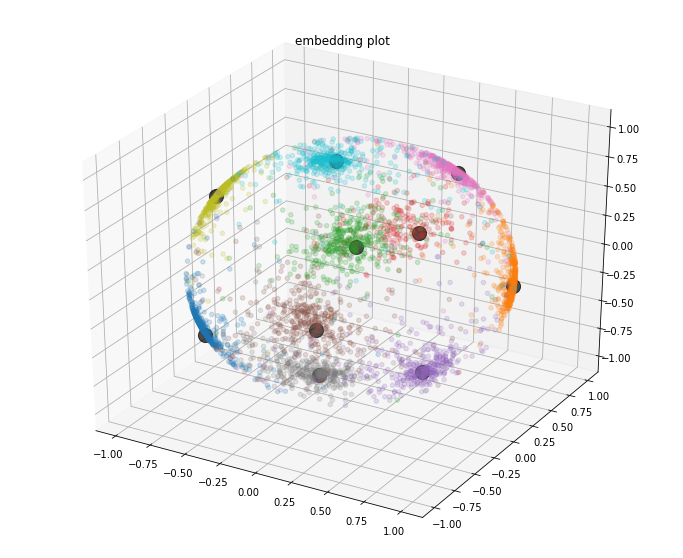

In [10]:
plt.figure(figsize=(12, 10))
ax = plt.axes(projection='3d')

for cls in range(10):
    mask = labels == cls
    ax.scatter3D(
        embeddigs[mask, 0], embeddigs[mask, 1], embeddigs[mask, 2],
        marker='o', alpha=0.2
    )
    ax.scatter3D(
        [centroids[cls, 0]], [centroids[cls, 1]], [centroids[cls, 2]],
        s=200, marker="o", c="black", alpha=0.7
    )

# plt.legend([f"{i // 2}" if i % 2 == 0 else f"{i // 2} centroid" for i in range(20)])
plt.title("embedding plot");